# 1 - Estimate when US Installs will reach EoL


Historical installations for U.S. Utility and non-Residential sector was calculated from:
1. 1995 through 1998: K. Bolcar and K. Ardani, “National Survey Report of PV Power Applications in the United States 2010,” IEA-PVPS, National Survey T1-19:2010, 2010. [Online]. Available: https://iea-pvps.org/national-survey-reports/.
2. L. Sherwood, “U.S. Solar Market Trends 2008,” Interstate Renewable Energy Council, Jul. 2009. Accessed: Sep. 15, 2021. [Online]. Available: https://irecusa.org/wp-content/uploads/2021/07/Solar-Market-Trends-2008.pdf
3. All Sherwood reports 2009-2014 for 1999 through 2009
4. Wood Mackenzie Data from 2010 forward.
5. “U.S. Solar Market Insight Report: 2012 Year in Review Full Report,” Greentech Media Inc. & SEIA, 2013 as a sanity check.

The calculations to select for only these 2 sectors and weight for c-Si can be found in Supporting Materials folder, files "Calculations-Installs-Subset-CommUtility.xlsx", "Installs-SubsetCommUtility.xlsx", and "Installs-SubsetCommUtility.csv".

These installations where then put into a module file. Installations after 2020 are set to 0, manufacturing efficiency is set to 100, and all circular EoL pathways are set to 0, sending all EoL material to the landfill. All lifetime and reliability, module efficiencies, and module degradation rates are taken from PV ICE baseline. The purpose of this calculation is to estimate when currently installed PV modules will come out of the field and need to be managed at EoL.

NOTE: this analysis has been updated for a 2022 release of an NREL decommissioning report. The update includes resolving a bug in how the Weibull function was applied to the cohorts, resolution of edge cases, and an update to the installation inputs, examining all 3 sectors of PV installs using Wood Mackenzie assumptions.

This analysis conducted for Taylor Curtis

In [1]:
import os
from pathlib import Path
import PV_ICE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
resultsfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial'/ 'USHistoryResults')

print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


In [2]:
PV_ICE.__version__

'v0.2.0+349.g4f1ea20.dirty'

### Set up Materials and Scenarios
These scenarios are all tech and silicon only, and split by sector as well as an all sector scenario.

In [3]:
cwd=os.getcwd()
print(os.getcwd())

C:\Users\hmirletz\Documents\GitHub\PV_ICE\docs\tutorials


In [4]:
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
moduleFile = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
newmodfilesPAth = os.path.join(supportMatfolder,'Calculations-Installs-Subset-CommUtility.xlsx')

In [5]:
newmoduleFile_raw = pd.read_excel(newmodfilesPAth, sheet_name='SectorInstalls', header=2)

In [6]:
newmoduleFile_raw.columns

Index(['year', 'Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Unnamed: 5', 'Comm+Utility',
       'Total', 'Source', 'Residential MrktShr', 'Commercial MrktShr',
       'Source.1', 'Utility MrktShr', 'Source.2', 'Unnamed: 14',
       'Residential c-Si', 'Commercial c-Si', 'Utility c-Si',
       'All Sector c-Si Installs_[MWdc]', 'Unnamed: 19', 'Residential.1',
       'Commercial.1', 'Utility.1', 'Residential.2', 'Commercial.2',
       'Utility.2', 'Source.3'],
      dtype='object')

In [7]:
installs_allPV_df = newmoduleFile_raw.loc[:,newmoduleFile_raw.columns[0:5]] # all PV tech installs
installs_cSiPV_df = newmoduleFile_raw.loc[:,['Residential c-Si', 'Commercial c-Si', 'Utility c-Si',
                                          'All Sector c-Si Installs_[MWdc]']] # c-Si PV tech installs
installs_df = pd.concat([installs_allPV_df, installs_cSiPV_df], axis=1)

In [8]:
installs_df.columns

Index(['year', 'Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Residential c-Si',
       'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]'],
      dtype='object')

### Modify the Simulation, create scenarios for each install/deployment history
Using the old/standard module baseline, we will modify/replace for each deployment schedule in the excel file. We will run the simulation for all tech and for just c-Si tech. For the all tech deployment, we will disregard the mass out since it it not representative of technologies (this will be improved in future). 

In [9]:
scennames = installs_df.columns[1:]
#['Residential', 'Commercial', 'Utility', 'All Sector All Tech Installs_[MWdc]',
#             'Residential c-Si', 'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]']
scennames

Index(['Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Residential c-Si',
       'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]'],
      dtype='object')

In [10]:
r1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scens in scennames: #create all scenarios
    r1.createScenario(name=scens, massmodulefile=moduleFile) #create the scenario, name and mod file attach
    for mat in MATERIALS:
        materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
        r1.scenario[scens].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


In [11]:
#modify the scenario for deployments
#IF WE GET SECTOR-wise T5-T90, modify here!
for scens in scennames:
    r1.scenario[scens].dataIn_m.loc[0:len(installs_df['year']-1),'new_Installed_Capacity_[MW]'] = installs_df[scens]

# make sure 2022 and forward installs = 0, change degradation, and remove circularity and MFG wastes
enddeploydat = installs_df['year'].iloc[-1]
r1.modifyScenario(scenarios=None, stage='new_Installed_Capacity_[MW]', value=0, start_year=enddeploydat)

r1.modifyScenario(scenarios=None, stage='mod_degradation', value=0.75, start_year=2016) #based on Jordan et al 2022 doi/pdf/10.1002/pip.3566
r1.scenMod_noCircularity() # sets all module and material circular variables to 0, creating fully linear
r1.scenMod_PerfectManufacturing() #sets all manufacturing values to 100% efficiency/yield ignoring MFG waste

#check:
#r1.scenario['USHistory'].material['glass'].materialdata['mat_MFG_eff']

In [12]:
r1.scenario['Utility c-Si'].dataIn_m

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled
0,1995,12.000000,12.500000,16.0,21.0,0.75,10.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
1,1996,0.000000,12.700000,16.0,21.0,0.75,10.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2,1997,0.000000,12.880000,19.0,23.0,0.75,15.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
3,1998,0.000000,13.060000,19.0,23.0,0.75,15.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
4,1999,0.000000,13.240000,19.0,23.0,0.75,15.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
5,2000,0.600000,13.420000,19.0,23.0,0.75,20.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
6,2001,3.700000,13.600000,19.0,23.0,0.75,20.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,2002,2.700000,13.722222,19.0,23.0,0.75,20.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
8,2003,3.600000,13.844444,19.0,23.0,0.75,20.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
9,2004,2.100000,13.966667,19.0,23.0,0.75,20.0,100.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


### Run the Mass Flow Calculations on All Scenarios and Materials

In [13]:
r1.calculateMassFlow()


>>>> Calculating Material Flows <<<<

Working on Scenario:  Residential
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
VAT carryover material is turned OFF
==> Working on Material :  aluminium_frames
VAT carryover material is turned OFF
==> Working on Material :  silver
VAT carryover material is turned OFF
==> Working on Material :  silicon
VAT carryover material is turned OFF
==> Working on Material :  copper
VAT carryover material is turned OFF
==> Working on Material :  encapsulant
VAT carryover material is turned OFF
==> Working on Material :  backsheet
VAT carryover material is turned OFF
Working on Scenario:  Commercial
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
VAT carryover material is turned OFF
==> Working on Material :  aluminium_frames
VAT carryover material is turned OFF
==> Working on Material :  silver
VAT carryover material is turned OFF
==> Working on Material :  s

###  Use internal plotting functions to plot results

Pull out the keywords by printing the keys to the module data or the material data:

    print(r1.scenario.keys())
    
    print(r1.scenario['standard'].data.keys())
    
    print(r1.scenario['standard'].material['glass'].materialdata.keys())

In [14]:
#print(r1.scenario.keys())
print(r1.scenario['All Sector All Tech Installs_[MWdc]'].dataOut_m.keys())
#print(r1.scenario['All Sector All Tech Installs_[MWdc]'].material['glass'].materialdata.keys())

Index(['Area', 'Area_for_EOL_pathsG', 'Cumulative_Active_Area', 'EOL_BS_Year0',
       'EOL_BS_Year1', 'EOL_BS_Year10', 'EOL_BS_Year11', 'EOL_BS_Year12',
       'EOL_BS_Year13', 'EOL_BS_Year14',
       ...
       'Status_BAD_[W]', 'WeibullParams', 'Yearly_Sum_Area_disposed',
       'Yearly_Sum_Area_disposedby_Failure',
       'Yearly_Sum_Area_disposedby_ProjectLifetime',
       'Yearly_Sum_Power_disposed', 'Yearly_Sum_Power_disposedby_Failure',
       'Yearly_Sum_Power_disposedby_ProjectLifetime', 'irradiance_stc',
       'landfilled_noncollected'],
      dtype='object', length=209)


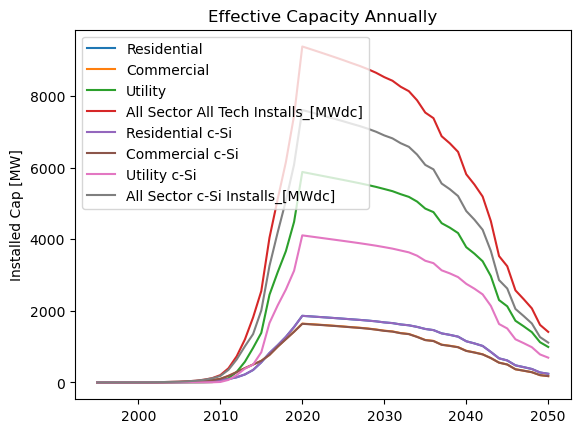

In [15]:
for scen in scennames:
    plt.plot(r1.scenario[scen].dataIn_m['year'], 
             r1.scenario[scen].dataOut_m['Installed_Capacity_[W]']/10e6, label=scen)

plt.title('Effective Capacity Annually')
plt.ylabel('Installed Cap [MW]')
plt.legend()

In [16]:
usyearlyr1, uscumr1 = r1.aggregateResults()
usyearlyr1.to_csv(os.path.join(resultsfolder,'historicalUS-yearly.csv'))
uscumr1.to_csv(os.path.join(resultsfolder,'historicalUS-cumulative.csv'))

Examine a specific year

In [17]:
#subset result dataframes to look at all tech and just cSi and remove old USHistory file

yearlycSi_agg = usyearlyr1.filter(like='c-Si')

filter_col = [col for col in usyearlyr1.columns if 'c-Si' not in col]
yearlyallPV_agg = usyearlyr1[filter_col]

## Area Equivilent Calcs

In [18]:
keys = pd.DataFrame(r1.scenario['All Sector All Tech Installs_[MWdc]'].dataOut_m.keys())
import re
keys[keys[0].str.contains('area', flags=re.IGNORECASE)]

,0
0,Area
1,Area_for_EOL_pathsG
2,Cumulative_Active_Area
194,Repaired_Area
196,Resold_Area
198,Status_BAD_Area
201,Yearly_Sum_Area_disposed
202,Yearly_Sum_Area_disposedby_Failure
203,Yearly_Sum_Area_disposedby_ProjectLifetime


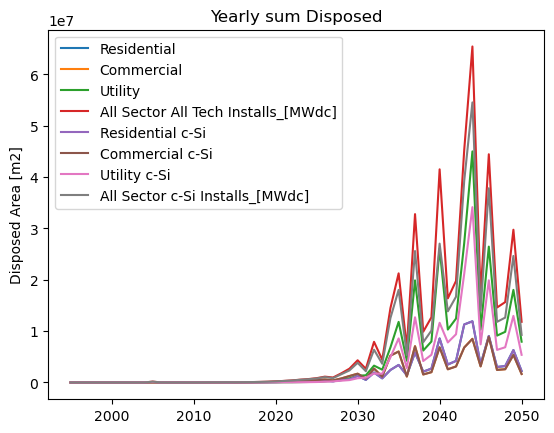

In [19]:
for scen in scennames:
    plt.plot(r1.scenario[scen].dataIn_m['year'], 
             r1.scenario[scen].dataOut_m['Yearly_Sum_Area_disposed'], label=scen)

plt.title('Yearly sum Disposed')
plt.ylabel('Disposed Area [m2]')
plt.legend()

In [20]:
#extract area disposed from simulation #should be m2
yearly_AreaDisposed_Results = pd.DataFrame()
for scen in scennames:
    temp = r1.scenario[scen].dataOut_m['Yearly_Sum_Area_disposed']
    yearly_AreaDisposed_Results = pd.concat([yearly_AreaDisposed_Results,temp], axis=1)

In [21]:
yearly_AreaDisposed_Results.index = r1.scenario['Residential'].dataIn_m['year']
yearly_AreaDisposed_Results.columns = scennames
yearly_AreaDisposed_Results.tail()

,Residential,Commercial,Utility,All Sector All Tech Installs_[MWdc],Residential c-Si,Commercial c-Si,Utility c-Si,All Sector c-Si Installs_[MWdc]
year,,,,,,,,
2046,9.064565e+06,8.925520e+06,2.645814e+07,4.444822e+07,9.064565e+06,8.868576e+06,1.989433e+07,3.782747e+07
2047,3.016970e+06,2.456374e+06,9.126808e+06,1.460015e+07,3.016970e+06,2.444178e+06,6.347214e+06,1.180836e+07
2048,3.199570e+06,2.588842e+06,9.865575e+06,1.565399e+07,3.199570e+06,2.576520e+06,6.858681e+06,1.263477e+07
2049,6.317650e+06,5.394183e+06,1.803730e+07,2.974913e+07,6.317650e+06,5.354415e+06,1.296832e+07,2.464039e+07
2050,2.220865e+06,1.656294e+06,7.941163e+06,1.181832e+07,2.220865e+06,1.654436e+06,5.388140e+06,9.263441e+06


In [22]:
yearly_AreaDisposed_Results_cum = yearly_AreaDisposed_Results.cumsum()
yearly_AreaDisposed_Results_cum.tail()

,Residential,Commercial,Utility,All Sector All Tech Installs_[MWdc],Residential c-Si,Commercial c-Si,Utility c-Si,All Sector c-Si Installs_[MWdc]
year,,,,,,,,
2046,7.741056e+07,7.421094e+07,2.256091e+08,3.772306e+08,7.741056e+07,7.401037e+07,1.567854e+08,3.082064e+08
2047,8.042753e+07,7.666732e+07,2.347359e+08,3.918307e+08,8.042753e+07,7.645455e+07,1.631327e+08,3.200147e+08
2048,8.362710e+07,7.925616e+07,2.446014e+08,4.074847e+08,8.362710e+07,7.903107e+07,1.699913e+08,3.326495e+08
2049,8.994475e+07,8.465034e+07,2.626387e+08,4.372338e+08,8.994475e+07,8.438549e+07,1.829597e+08,3.572899e+08
2050,9.216561e+07,8.630664e+07,2.705799e+08,4.490521e+08,9.216561e+07,8.603992e+07,1.883478e+08,3.665533e+08


Now we take the area and divide it by 1.6 m2 or 2 m2 to approximate the # of modules. And Also extract the 2030 and 2050 values for area equivilence estimations.

In [23]:
subset_areaDisposed_yearly = yearly_AreaDisposed_Results.loc[[2030,2050]]
subset_areaDisposed_cum = yearly_AreaDisposed_Results_cum.loc[[2030,2050]]

In [24]:
subset_1pt6m2ModulesDisposed_yearly = subset_areaDisposed_yearly/1.6
subset_1pt6m2ModulesDisposed_cum = subset_areaDisposed_cum/1.6
subset_2m2ModulesDisposed_yearly = subset_areaDisposed_yearly/2
subset_2m2ModulesDisposed_cum = subset_areaDisposed_cum/2
idxmulti = pd.MultiIndex.from_arrays([['yearly','yearly','cumulative','cumulative'],['1.6m$^2$','2m$^2$','1.6m$^2$','2m$^2$']])
subset_NoModules = pd.concat([subset_1pt6m2ModulesDisposed_yearly,
           subset_2m2ModulesDisposed_yearly,
           subset_1pt6m2ModulesDisposed_cum,
           subset_2m2ModulesDisposed_cum],
         keys = idxmulti)
subset_NoModules.to_csv(os.path.join(resultsfolder,'US_Historical_NoModulesDisposed.csv'))
subset_NoModules

Residential    Commercial       Utility  \
                    year                                             
yearly     1.6m$^2$ 2030  8.076550e+05  1.070405e+06  8.241417e+05   
                    2050  1.388040e+06  1.035183e+06  4.963227e+06   
           2m$^2$   2030  6.461240e+05  8.563243e+05  6.593134e+05   
                    2050  1.110432e+06  8.281468e+05  3.970582e+06   
cumulative 1.6m$^2$ 2030  2.628510e+06  4.118820e+06  2.355229e+06   
                    2050  5.760351e+07  5.394165e+07  1.691124e+08   
           2m$^2$   2030  2.102808e+06  3.295056e+06  1.884183e+06   
                    2050  4.608281e+07  4.315332e+07  1.352899e+08   

                          All Sector All Tech Installs_[MWdc]  \
                    year                                        
yearly     1.6m$^2$ 2030                         2.702202e+06   
                    2050                         7.386451e+06   
           2m$^2$   2030                         2.161762e+06   
                    2050                         5.909161e+06   
cumulative 1.6m$^2$ 2030                         9.102560e+06   
                    2050                         2.806576e+08   
           2m$^2$   2030                         7.282048e+06   
                    2050                         2.245261e+08   

                          Residential c-Si  Commercial c-Si  Utility c-Si  \
                    year                                                    
yearly     1.6m$^2$ 2030      8.076550e+05     1.070220e+06  5.140425e+05   
                    2050      1.388040e+06     1.034023e+06  3.367588e+06   
           2m$^2$   2030      6.461240e+05     8.561756e+05  4.112340e+05   
                    2050      1.110432e+06     8.272181e+05  2.694070e+06   
cumulative 1.6m$^2$ 2030      2.628510e+06     4.118388e+06  1.506756e+06   
                    2050      5.760351e+07     5.377495e+07  1.177174e+08   
           2m$^2$   2030      2.102808e+06     3.294711e+06  1.205404e+06   
                    2050      4.608281e+07     4.301996e+07  9.417390e+07   

                          All Sector c-Si Installs_[MWdc]  
                    year                                   
yearly     1.6m$^2$ 2030                     2.391917e+06  
                    2050                     5.789651e+06  
           2m$^2$   2030                     1.913534e+06  
                    2050                     4.631721e+06  
cumulative 1.6m$^2$ 2030                     8.253654e+06  
                    2050                     2.290958e+08  
           2m$^2$   2030                     6.602923e+06  
                    2050                     1.832767e+08

In [25]:
AreaDisposed_Eq = pd.concat([subset_areaDisposed_yearly,subset_areaDisposed_cum], keys = ['yearly','cumulative'])
AreaDisposed_Eq.to_csv(os.path.join(resultsfolder, 'US_Historical_AreaDisposed_EQ.csv'))
AreaDisposed_Eq

Residential    Commercial       Utility  \
           year                                             
yearly     2030  1.292248e+06  1.712649e+06  1.318627e+06   
           2050  2.220865e+06  1.656294e+06  7.941163e+06   
cumulative 2030  4.205617e+06  6.590113e+06  3.768367e+06   
           2050  9.216561e+07  8.630664e+07  2.705799e+08   

                 All Sector All Tech Installs_[MWdc]  Residential c-Si  \
           year                                                          
yearly     2030                         4.323523e+06      1.292248e+06   
           2050                         1.181832e+07      2.220865e+06   
cumulative 2030                         1.456410e+07      4.205617e+06   
           2050                         4.490521e+08      9.216561e+07   

                 Commercial c-Si  Utility c-Si  \
           year                                  
yearly     2030     1.712351e+06  8.224680e+05   
           2050     1.654436e+06  5.388140e+06   
cumulative 2030     6.589421e+06  2.410809e+06   
           2050     8.603992e+07  1.883478e+08   

                 All Sector c-Si Installs_[MWdc]  
           year                                   
yearly     2030                     3.827067e+06  
           2050                     9.263441e+06  
cumulative 2030                     1.320585e+07  
           2050                     3.665533e+08

### in 2022

In [26]:
#annual
round(yearly_AreaDisposed_Results.loc[[2022]]/1.6,0)

,Residential,Commercial,Utility,All Sector All Tech Installs_[MWdc],Residential c-Si,Commercial c-Si,Utility c-Si,All Sector c-Si Installs_[MWdc]
year,,,,,,,,
2022,90935.0,131892.0,30112.0,252938.0,90935.0,131891.0,21627.0,244453.0


In [27]:
#cumulative
round(yearly_AreaDisposed_Results_cum.loc[[2022]]/1.6,0)

,Residential,Commercial,Utility,All Sector All Tech Installs_[MWdc],Residential c-Si,Commercial c-Si,Utility c-Si,All Sector c-Si Installs_[MWdc]
year,,,,,,,,
2022,387681.0,474831.0,152267.0,1014779.0,387681.0,474830.0,132323.0,994834.0


# Table of decommissioned in MW
decommissioned yearly = cumulative new installs - yearly active capacity

the decommissioned yearly column is cumulative, therefore we need to create an annual

Create a table output of installs, active generating capacity annually decommissioned, cumulatively decomissioned, and cumulative decomissioned module mass.

In [28]:
df_Capacity_all = usyearlyr1[usyearlyr1.filter(like='[MW]').columns]

In [29]:
capacity_results_alltech = yearlyallPV_agg.filter(like='[MW]')
capacity_results_cSi = yearlycSi_agg.filter(like='[MW]')


In [30]:
#caution, run this only once
for colname in df_Capacity_all.filter(like='Decommisioned').columns:
    df_Capacity_all[str('Annual_'+colname)] = df_Capacity_all[colname]-df_Capacity_all[colname].shift(1).fillna(0)


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3548\572765195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Capacity_all[str('Annual_'+colname)] = df_Capacity_all[colname]-df_Capacity_all[colname].shift(1).fillna(0)
C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3548\572765195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Capacity_all[str('Annual_'+colname)] = df_Capacity_all[colname]-df_Capacity_all[colname].shift(1).fillna(0)
C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3548\5727

In [31]:
df_Capacity_all.to_csv(os.path.join(resultsfolder, 'US_Historical_PV_Decomissioning_Sectorwise.csv'))

In [32]:
df_Capacity_all.filter(like='DecommisionedCapacity_sim1_Residential_[MW]')#.shift(1)#.fillna(0)

,DecommisionedCapacity_sim1_Residential_[MW],Annual_DecommisionedCapacity_sim1_Residential_[MW]
year,,
1995,0.000000,0.000000
1996,0.072782,0.072782
1997,0.155391,0.082609
1998,0.260442,0.105051
1999,0.388495,0.128053
2000,0.530045,0.141550
2001,0.695077,0.165032
2002,0.939234,0.244157
2003,1.321284,0.382050


### Pull out the 2030 and 2050 Values of interest
the request was for 2030 and 2050 values for decommissioning and cumulative c-Si waste, by sector. Create a table of just those results.

In [33]:
subset_results_capacity = df_Capacity_all.filter(like='Decommisioned').loc[[2022,2030,2050]]
subset_results_capacity.T.to_csv(os.path.join(resultsfolder, 'US_Historical_PV_Decomissioning20302050_Sectorwise.csv'))
round(subset_results_capacity.T,)

year,2022,2030,2050
DecommisionedCapacity_sim1_Residential_[MW],825.0,2349.0,16700.0
DecommisionedCapacity_sim1_Commercial_[MW],843.0,2519.0,15209.0
DecommisionedCapacity_sim1_Utility_[MW],2191.0,6058.0,50169.0
DecommisionedCapacity_sim1_All Sector All Tech Installs_[MWdc]_[MW],3858.0,10926.0,82079.0
DecommisionedCapacity_sim1_Residential c-Si_[MW],825.0,2349.0,16700.0
DecommisionedCapacity_sim1_Commercial c-Si_[MW],841.0,2514.0,15161.0
DecommisionedCapacity_sim1_Utility c-Si_[MW],1509.0,4178.0,35045.0
DecommisionedCapacity_sim1_All Sector c-Si Installs_[MWdc]_[MW],3174.0,9041.0,66906.0
Annual_DecommisionedCapacity_sim1_Residential_[MW],157.0,294.0,366.0
Annual_DecommisionedCapacity_sim1_Commercial_[MW],149.0,331.0,272.0


In [34]:
#cumulative wastes
cSiwaste_cum = uscumr1.filter(like='WasteAll_Module').filter(like='c-Si')/1e6 #convert to million metric tonnes
subset_results_waste = cSiwaste_cum.loc[[2022,2030,2050]].add_suffix('_[million Tonnes]')

cSiwaste_annual = usyearlyr1.filter(like='WasteAll_Module').filter(like='c-Si')
subset_results_waste_annual = cSiwaste_annual.loc[[2022,2030,2050]].add_prefix('Annual_')

cSi_wastes_results = pd.concat([subset_results_waste.T,subset_results_waste_annual.T])
cSi_wastes_results = round(cSi_wastes_results,2)
cSi_wastes_results

year,2022,2030,2050
WasteAll_Module_sim1_Residential c-Si_[Tonnes]_[million Tonnes],0.01,0.05,1.06
WasteAll_Module_sim1_Commercial c-Si_[Tonnes]_[million Tonnes],0.01,0.08,0.99
WasteAll_Module_sim1_Utility c-Si_[Tonnes]_[million Tonnes],0.00,0.03,2.17
WasteAll_Module_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes],0.02,0.15,4.23
Annual_WasteAll_Module_sim1_Residential c-Si_[Tonnes],1735.32,15034.15,26254.01
Annual_WasteAll_Module_sim1_Commercial c-Si_[Tonnes],2503.16,19940.96,19550.89
Annual_WasteAll_Module_sim1_Utility c-Si_[Tonnes],410.98,9542.85,63913.32
Annual_WasteAll_Module_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes],4649.46,44517.95,109718.22


In [35]:
power_and_allwastes = pd.concat([subset_results_capacity.T,cSi_wastes_results])
power_and_allwastes.to_csv(os.path.join(resultsfolder, 'DecommissionsAllWastes_now20302050_perfMFG.csv'))
power_and_allwastes

year,2022,2030,2050
DecommisionedCapacity_sim1_Residential_[MW],824.640032,2349.194737,16700.499892
DecommisionedCapacity_sim1_Commercial_[MW],842.569247,2518.991100,15209.425795
DecommisionedCapacity_sim1_Utility_[MW],2190.999729,6057.571432,50168.992290
DecommisionedCapacity_sim1_All Sector All Tech Installs_[MWdc]_[MW],3858.209009,10925.757269,82078.917977
DecommisionedCapacity_sim1_Residential c-Si_[MW],824.640032,2349.194737,16700.499892
DecommisionedCapacity_sim1_Commercial c-Si_[MW],840.853080,2514.232701,15160.597289
DecommisionedCapacity_sim1_Utility c-Si_[MW],1508.870908,4177.878564,35044.686404
DecommisionedCapacity_sim1_All Sector c-Si Installs_[MWdc]_[MW],3174.364020,9041.306001,66905.783586
Annual_DecommisionedCapacity_sim1_Residential_[MW],156.558004,294.486530,365.811086
Annual_DecommisionedCapacity_sim1_Commercial_[MW],148.775486,330.577762,272.410850


In [36]:
subset_results_waste.T.to_csv(os.path.join(resultsfolder,'US_Historical_PV_cSiWaste20302050_Sectorwise.csv'))
round(subset_results_waste.T,2)
#subset_results_waste.to_csv(path_or_buf=r'..\baselines\SupportingMaterial\US_Historical_PV_cSiWaste20302050_Sectorwise.csv')
round(subset_results_waste_annual.T,2)

year,2022,2030,2050
Annual_WasteAll_Module_sim1_Residential c-Si_[Tonnes],1735.32,15034.15,26254.01
Annual_WasteAll_Module_sim1_Commercial c-Si_[Tonnes],2503.16,19940.96,19550.89
Annual_WasteAll_Module_sim1_Utility c-Si_[Tonnes],410.98,9542.85,63913.32
Annual_WasteAll_Module_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes],4649.46,44517.95,109718.22


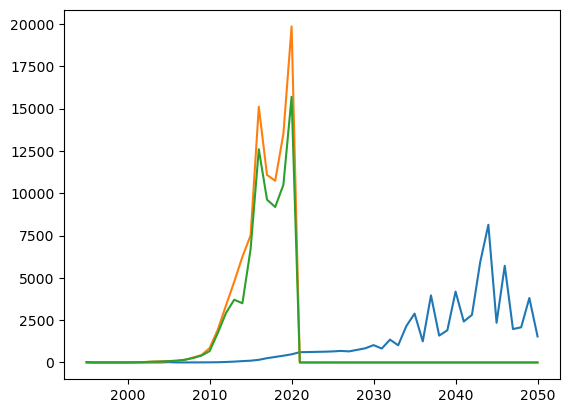

In [37]:
annualdecommissioncSi = df_Capacity_all.filter(like='Annual_Decommisioned').filter(like='All Sector c-Si')
plt.plot(annualdecommissioncSi)
installs = df_Capacity_all.filter(like='newInstalledCapacity').filter(like='All Sector')
plt.plot(installs)

In [38]:
annualdecommissioncSi.sum()

Annual_DecommisionedCapacity_sim1_All Sector c-Si Installs_[MWdc]_[MW]    66905.783586
dtype: float64

In [39]:
installs.iloc[:,1].sum()

78042.16032120853

## Pretty Plots

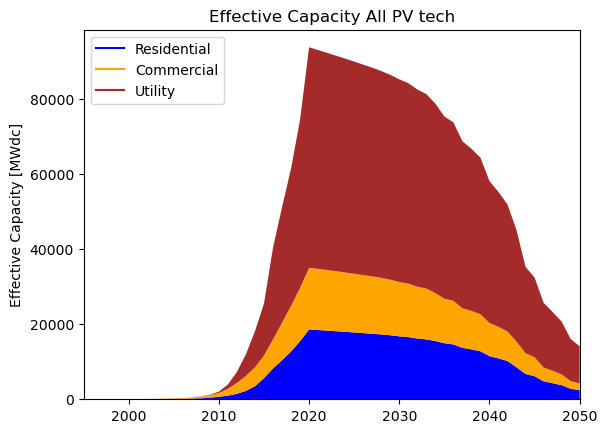

In [40]:
#all techs plot
plt.plot([],[],color='blue', label='Residential')
plt.plot([],[],color='orange', label='Commercial')
plt.plot([],[],color='brown', label='Utility')


plt.stackplot(yearlyallPV_agg.index, 
              yearlyallPV_agg['ActiveCapacity_sim1_Residential_[MW]'], 
              yearlyallPV_agg['ActiveCapacity_sim1_Commercial_[MW]'],
              yearlyallPV_agg['ActiveCapacity_sim1_Utility_[MW]'], 
              colors = ['blue','orange','brown'])
plt.title('Effective Capacity All PV tech')
plt.ylabel('Effective Capacity [MWdc]')
plt.xlim(1995,2050)
plt.legend(loc='upper left')
plt.show()

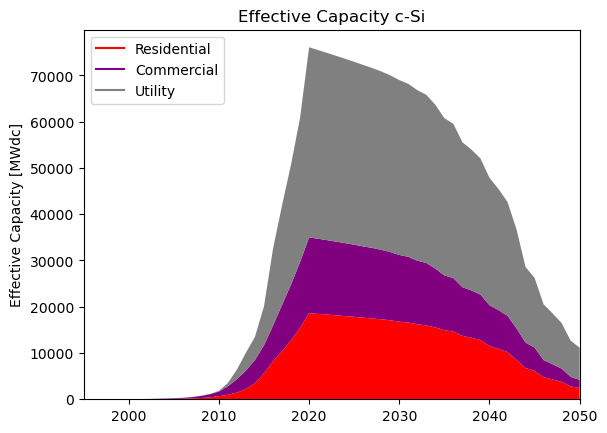

In [41]:
#cSi plot
plt.plot([],[],color='red', label='Residential')
plt.plot([],[],color='purple', label='Commercial')
plt.plot([],[],color='grey', label='Utility')


plt.stackplot(yearlycSi_agg.index, 
              yearlycSi_agg['ActiveCapacity_sim1_Residential c-Si_[MW]'], 
              yearlycSi_agg['ActiveCapacity_sim1_Commercial c-Si_[MW]'],
              yearlycSi_agg['ActiveCapacity_sim1_Utility c-Si_[MW]'], 
              colors = ['red','purple','grey'])
plt.title('Effective Capacity c-Si')
plt.ylabel('Effective Capacity [MWdc]')
plt.xlim(1995,2050)
plt.legend(loc='upper left')
plt.show()

In [42]:
yearlyallPV_agg.filter(like='Decommisioned').columns

Index(['DecommisionedCapacity_sim1_Residential_[MW]',
       'DecommisionedCapacity_sim1_Commercial_[MW]',
       'DecommisionedCapacity_sim1_Utility_[MW]',
       'DecommisionedCapacity_sim1_All Sector All Tech Installs_[MWdc]_[MW]'],
      dtype='object')

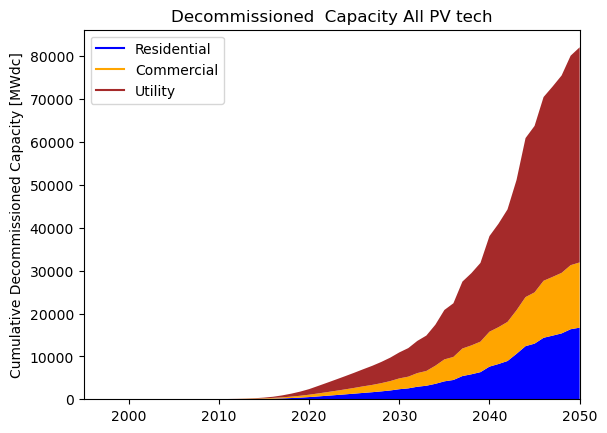

In [43]:
#all techs plot
plt.plot([],[],color='blue', label='Residential')
plt.plot([],[],color='orange', label='Commercial')
plt.plot([],[],color='brown', label='Utility')


plt.stackplot(yearlyallPV_agg.index, 
              yearlyallPV_agg['DecommisionedCapacity_sim1_Residential_[MW]'], 
              yearlyallPV_agg['DecommisionedCapacity_sim1_Commercial_[MW]'],
              yearlyallPV_agg['DecommisionedCapacity_sim1_Utility_[MW]'], 
              colors = ['blue','orange','brown'])
plt.title('Decommissioned  Capacity All PV tech')
plt.ylabel('Cumulative Decommissioned Capacity [MWdc]')
plt.xlim(1995,2050)
plt.legend(loc='upper left')
plt.show()

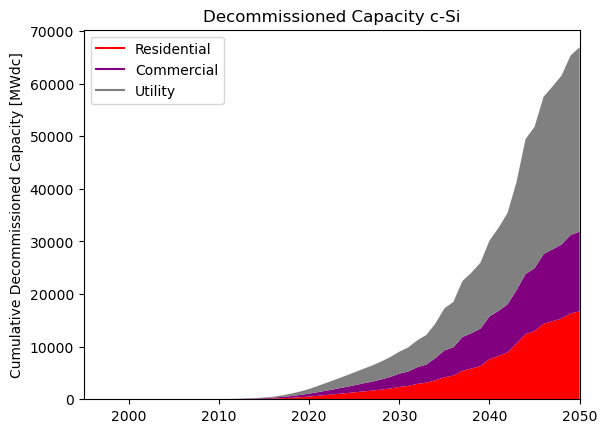

In [44]:
#cSi plot
plt.plot([],[],color='red', label='Residential')
plt.plot([],[],color='purple', label='Commercial')
plt.plot([],[],color='grey', label='Utility')


plt.stackplot(yearlycSi_agg.index, 
              yearlycSi_agg['DecommisionedCapacity_sim1_Residential c-Si_[MW]'], 
              yearlycSi_agg['DecommisionedCapacity_sim1_Commercial c-Si_[MW]'],
              yearlycSi_agg['DecommisionedCapacity_sim1_Utility c-Si_[MW]'], 
              colors = ['red','purple','grey'])
plt.title('Decommissioned Capacity c-Si')
plt.ylabel('Cumulative Decommissioned Capacity [MWdc]')
plt.xlim(1995,2050)
plt.legend(loc='upper left')
plt.show()

In [45]:
cSiMatWastes_cum = uscumr1.filter(like='WasteAll').filter(like='c-Si').filter(like='All Sector')/1e6 #convert to million metric tonnes
cSiMatWastes_cum = cSiMatWastes_cum.add_suffix('_[million Tonnes]')
cSiMatWastes_cum.columns

Index(['WasteAll_glass_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_aluminium_frames_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_silver_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_silicon_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_copper_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_encapsulant_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_backsheet_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]',
       'WasteAll_Module_sim1_All Sector c-Si Installs_[MWdc]_[Tonnes]_[million Tonnes]'],
      dtype='object')

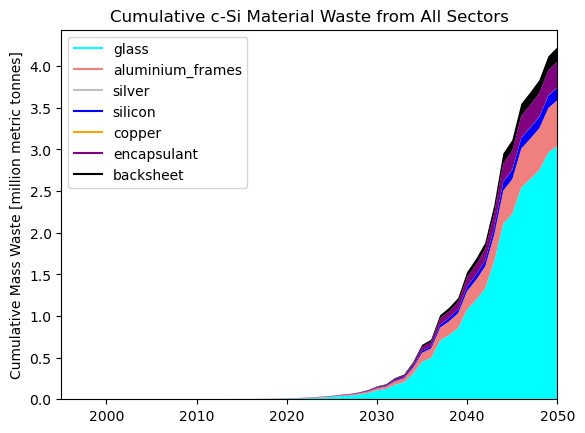

In [46]:
#cSi plot
plt.plot([],[],color='aqua', label='glass')
plt.plot([],[],color='lightcoral', label='aluminium_frames')
plt.plot([],[],color='silver', label='silver')
plt.plot([],[],color='blue', label='silicon')
plt.plot([],[],color='orange', label='copper')
plt.plot([],[],color='purple', label='encapsulant')
plt.plot([],[],color='black', label='backsheet')


plt.stackplot(cSiMatWastes_cum.index, 
              cSiMatWastes_cum.iloc[:,0], 
              cSiMatWastes_cum.iloc[:,1],
              cSiMatWastes_cum.iloc[:,2],
              cSiMatWastes_cum.iloc[:,3],
              cSiMatWastes_cum.iloc[:,4],
              cSiMatWastes_cum.iloc[:,5],
              cSiMatWastes_cum.iloc[:,6],
              colors = ['aqua','lightcoral','silver','blue','orange','purple','black'])
plt.title('Cumulative c-Si Material Waste from All Sectors')
plt.ylabel('Cumulative Mass Waste [million metric tonnes]')
plt.xlim(1995,2050)
plt.legend(loc='upper left')
plt.show()

In [47]:
#2050 stacked bar graph of cumulative waste by Material
